# Drag from Tides

This adds a constant time lag model (Hut 1981) to tides raised on either the primary and/or the orbiting bodies.
As an example, we'll add the tides raised on a post-main sequence Sun near its tip-RGB phase by the Earth.

In [1]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def getsim():
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun') 
    sim.add(m=0.86)        # post-MS Sun
    sim.add(m=3.e-6, a=1., e=0.03) # Earth
    sim.move_to_com()
    rebx = reboundx.Extras(sim)
    tides = rebx.load_force("tides_constant_time_lag")
    rebx.add_force(tides)

    return sim, rebx, tides

We specify the primary and secondaries' equilibrium gravitational response to the tidal field acting on them through the `tctl_k1` apsidal motion constant, equal to half the tidal Love number $k_2$. If we additionally give the primary a physical radius, then any (massive) orbiting body will raise equilibrium tides on the primary. Similarly, if we add a physical radius and `tctl_k1` to any of the orbiting bodies, the primary will raise tides on that particle (but note that orbiting bodies will not raise tides on one another):

In [2]:
sim, rebx, tides = getsim()
ps = sim.particles
ps[0].r = 0.85 # AU
ps[0].params["tctl_k1"] = 0.03

If we stop here and don't add a time lag, we will get the instantaneous equilibrium tide, which provides a conservative, radial non-Keplerian potential. The total energy will be conserved, but the pericenter will precess. 

In [3]:
H0 = sim.calculate_energy() + rebx.tides_constant_time_lag_potential(tides)
tmax = 5000
Nout=1000

pomega, Eerr = np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0,tmax,Nout)

for i, time in enumerate(times):
    sim.integrate(time)
    pomega[i] = ps[1].pomega
    H = sim.calculate_energy() + rebx.tides_constant_time_lag_potential(tides)
    Eerr[i] = abs((H-H0)/H0)

Text(0,0.5,'Energy Error')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


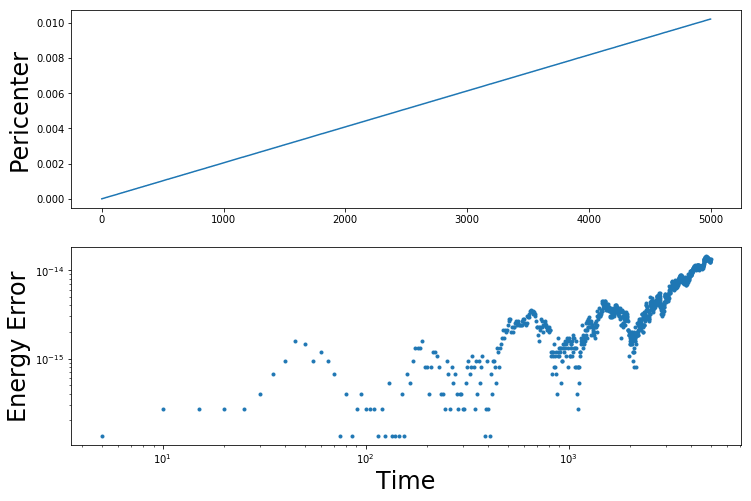

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axarr = plt.subplots(nrows=2, figsize=(12,8))
axarr[0].plot(times, pomega)
axarr[0].set_ylabel("Pericenter", fontsize=24)
axarr[1].plot(times, Eerr, '.')
axarr[1].set_xscale('log')
axarr[1].set_yscale('log')
axarr[1].set_xlabel('Time', fontsize=24)
axarr[1].set_ylabel('Energy Error', fontsize=24)

If we additionally set the `tctl_tau` constant time lag parameter, this delayed response introduces dissipation, which will typically cause eccentricity damping, and will migrate the orbiting bodies either inward or outward depending on whether they orbit faster or slower than the spin of the tidally deformed body. We set the spin rate of each body with the `Omega` parameter. If it is not set, `Omega` is assumed to be zero.

We note that this implementation assumes bodies' spins are fixed, so consider whether more angular momentum is being changed in the system than is available in the spins! We additionally assume that bodies spins are aligned with the reference z axis. 

As an example:

In [5]:
sim, rebx, tides = getsim()
ps = sim.particles
ps[0].r = 0.85 # AU
ps[0].params["tctl_k1"] = 0.03
ps[0].params["tctl_tau"] = 0.4
ps[0].params["Omega"] = 1./12. # one month

We can compare to the theoretical prediction assuming a circular orbit (see Hut 1981). We'll integrate for 25,000 years and store the Earth's semi-major axis and eccentricity.

In [6]:
import numpy as np
tmax = 2.5e4
Nout=1000

a, e = np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0,tmax,Nout)
# to plot physical radius of the Sun
R0 = 0*times + ps[0].r

q = (ps[1].m/ps[0].m)
T = ps[0].r**3/sim.G/ps[0].m/ps[0].params["tctl_tau"]
apred = ps[0].r*((ps[1].a/ps[0].r)**8 - 48.*ps[0].params["tctl_k1"]*q*(1+q)*times/T)**(1./8.)

In [7]:
%%time
for i, time in enumerate(times):
    sim.integrate(time)
    a[i] = ps[1].a
    e[i] = ps[1].e

CPU times: user 8.21 s, sys: 19.3 ms, total: 8.23 s
Wall time: 8.39 s


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


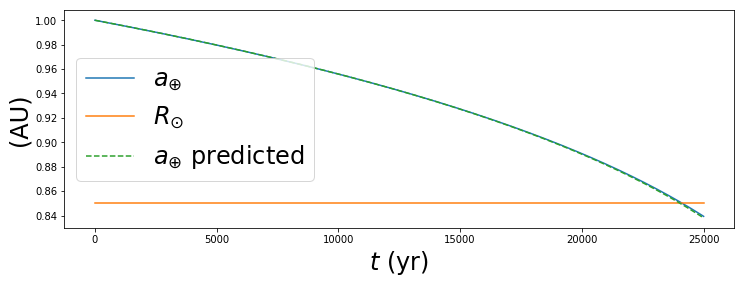

In [8]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(times, a, label='$a_{\oplus}$')
ax.plot(times, R0, label='$R_{\odot}$')
ax.plot(times, apred, '--', label='$a_{\oplus}$ predicted')
ax.set_xlabel('$t$ (yr)', fontsize=24)
ax.set_ylabel('(AU)', fontsize=24)
ax.legend(fontsize=24, loc='best')

We can also check that the eccentricity decays:

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


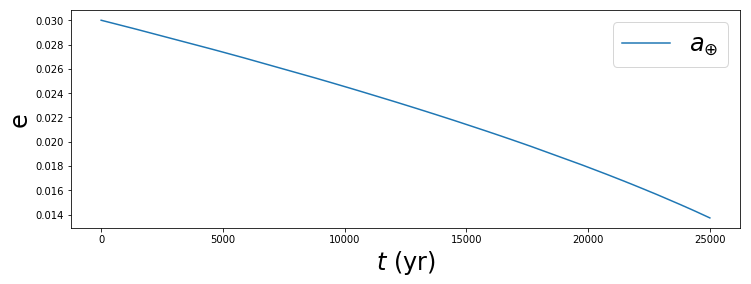

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(times, e, label='$a_{\oplus}$')
ax.set_xlabel('$t$ (yr)', fontsize=24)
ax.set_ylabel('e', fontsize=24)
ax.legend(fontsize=24, loc='best')